In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [8]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df['quarter'] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=['quarter'])
df.set_index('Date', inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


# Scaling

In [10]:
df.Temp = df.Temp.transform(lambda x: (x - x.mean()/x.std()))

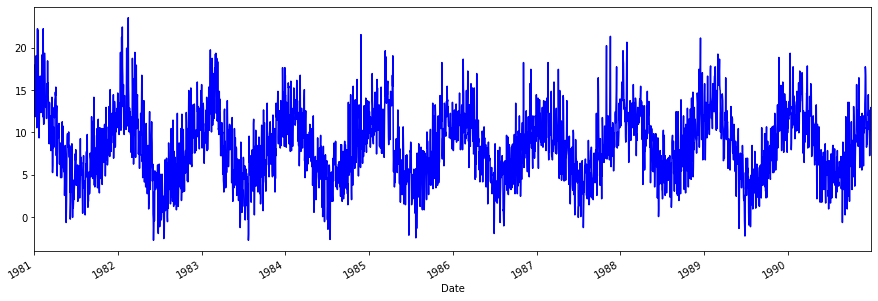

In [11]:
df.Temp.plot(figsize=(15,5), color='b')

# Dataset Splitting

In [12]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Dataloader

In [13]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [35]:
bs = 32
seq_len = 14

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 5)
Note: last 7 data excluded

(N, S, F): (52, 14, 5)
Note: last 1 data excluded



# Arsitektur

In [36]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [46]:
config = set_config({
    'input_size': 5,
    'output_size': 1,
    'seq_len': train_set.n_seq,
    'hidden_size': 128,
    'num_layers': 3,
    'dropout': 0
})

# Training Preparation

In [47]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.005)
callback = Callback(model, config, outdir="model/gru")

# Training

In [48]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 39.7169 | Test_cost  = 16.9663 | 




Epoch     2
Train_cost  = 17.4197 | Test_cost  = 17.0427 | 
==> EarlyStop patience =  1 | Best test_cost: 16.9663




Epoch     3
Train_cost  = 16.5080 | Test_cost  = 17.4183 | 
==> EarlyStop patience =  2 | Best test_cost: 16.9663




Epoch     4
Train_cost  = 16.6069 | Test_cost  = 17.5385 | 
==> EarlyStop patience =  3 | Best test_cost: 16.9663




Epoch     5
Train_cost  = 16.4037 | Test_cost  = 16.7909 | 




Epoch     6
Train_cost  = 16.3601 | Test_cost  = 16.7776 | 




Epoch     7
Train_cost  = 16.2690 | Test_cost  = 17.0388 | 
==> EarlyStop patience =  1 | Best test_cost: 16.7776




Epoch     8
Train_cost  = 16.1825 | Test_cost  = 16.9353 | 
==> EarlyStop patience =  2 | Best test_cost: 16.7776




Epoch     9
Train_cost  = 15.9329 | Test_cost  = 16.7491 | 




Epoch    10
Train_cost  = 15.8506 | Test_cost  = 16.7530 | 
==> EarlyStop patience =  1 | Best test_cost: 16.7491




Epoch    11
Train_cost  = 15.7709 | Test_cost  = 16.5761 | 




Epoch    12
Train_cost  = 15.6908 | Test_cost  = 16.5353 | 




Epoch    13
Train_cost  = 15.4593 | Test_cost  = 16.3751 | 




Epoch    14
Train_cost  = 15.3203 | Test_cost  = 16.1288 | 




Epoch    15
Train_cost  = 15.1556 | Test_cost  = 15.6472 | 




Epoch    16
Train_cost  = 14.6142 | Test_cost  = 15.0306 | 




Epoch    17
Train_cost  = 14.0334 | Test_cost  = 14.1635 | 




Epoch    18
Train_cost  = 12.8603 | Test_cost  = 10.9701 | 




Epoch    19
Train_cost  = 10.4368 | Test_cost  = 8.3679 | 




Epoch    20
Train_cost  = 9.0912 | Test_cost  = 7.7758 | 


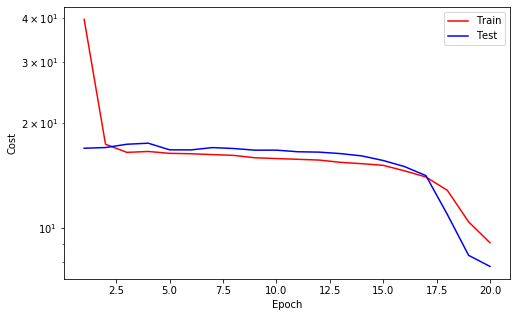



Epoch    21
Train_cost  = 7.7250 | Test_cost  = 6.3319 | 




Epoch    22
Train_cost  = 6.9861 | Test_cost  = 5.7771 | 




Epoch    23
Train_cost  = 6.5425 | Test_cost  = 5.3624 | 




Epoch    24
Train_cost  = 6.3566 | Test_cost  = 5.1762 | 




Epoch    25
Train_cost  = 6.1919 | Test_cost  = 5.0090 | 




Epoch    26
Train_cost  = 6.0632 | Test_cost  = 4.9994 | 




Epoch    27
Train_cost  = 5.9782 | Test_cost  = 4.9623 | 




Epoch    28
Train_cost  = 5.9342 | Test_cost  = 4.8738 | 




Epoch    29
Train_cost  = 5.8403 | Test_cost  = 4.9219 | 
==> EarlyStop patience =  1 | Best test_cost: 4.8738




Epoch    30
Train_cost  = 5.7919 | Test_cost  = 4.9512 | 
==> EarlyStop patience =  2 | Best test_cost: 4.8738




Epoch    31
Train_cost  = 5.7826 | Test_cost  = 4.9051 | 
==> EarlyStop patience =  3 | Best test_cost: 4.8738




Epoch    32
Train_cost  = 5.7481 | Test_cost  = 4.8283 | 




Epoch    33
Train_cost  = 5.6904 | Test_cost  = 4.9467 | 
==> EarlyStop patience =  1 | Best test_cost: 4.8283




Epoch    34
Train_cost  = 5.6548 | Test_cost  = 4.9828 | 
==> EarlyStop patience =  2 | Best test_cost: 4.8283




Epoch    35
Train_cost  = 5.6764 | Test_cost  = 5.0538 | 
==> EarlyStop patience =  3 | Best test_cost: 4.8283




Epoch    36
Train_cost  = 5.6695 | Test_cost  = 5.0047 | 
==> EarlyStop patience =  4 | Best test_cost: 4.8283




Epoch    37
Train_cost  = 5.6165 | Test_cost  = 5.0655 | 
==> EarlyStop patience =  5 | Best test_cost: 4.8283
==> Execute Early Stopping at epoch: 37 | Best test_cost: 4.8283
==> Best model is saved at model/gru


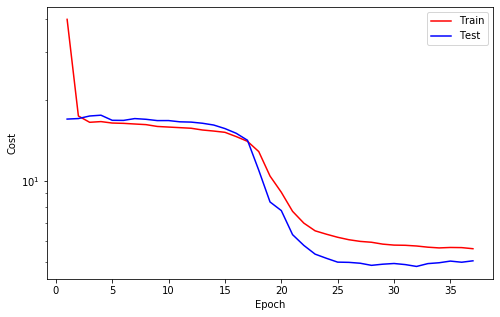

In [49]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)
    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

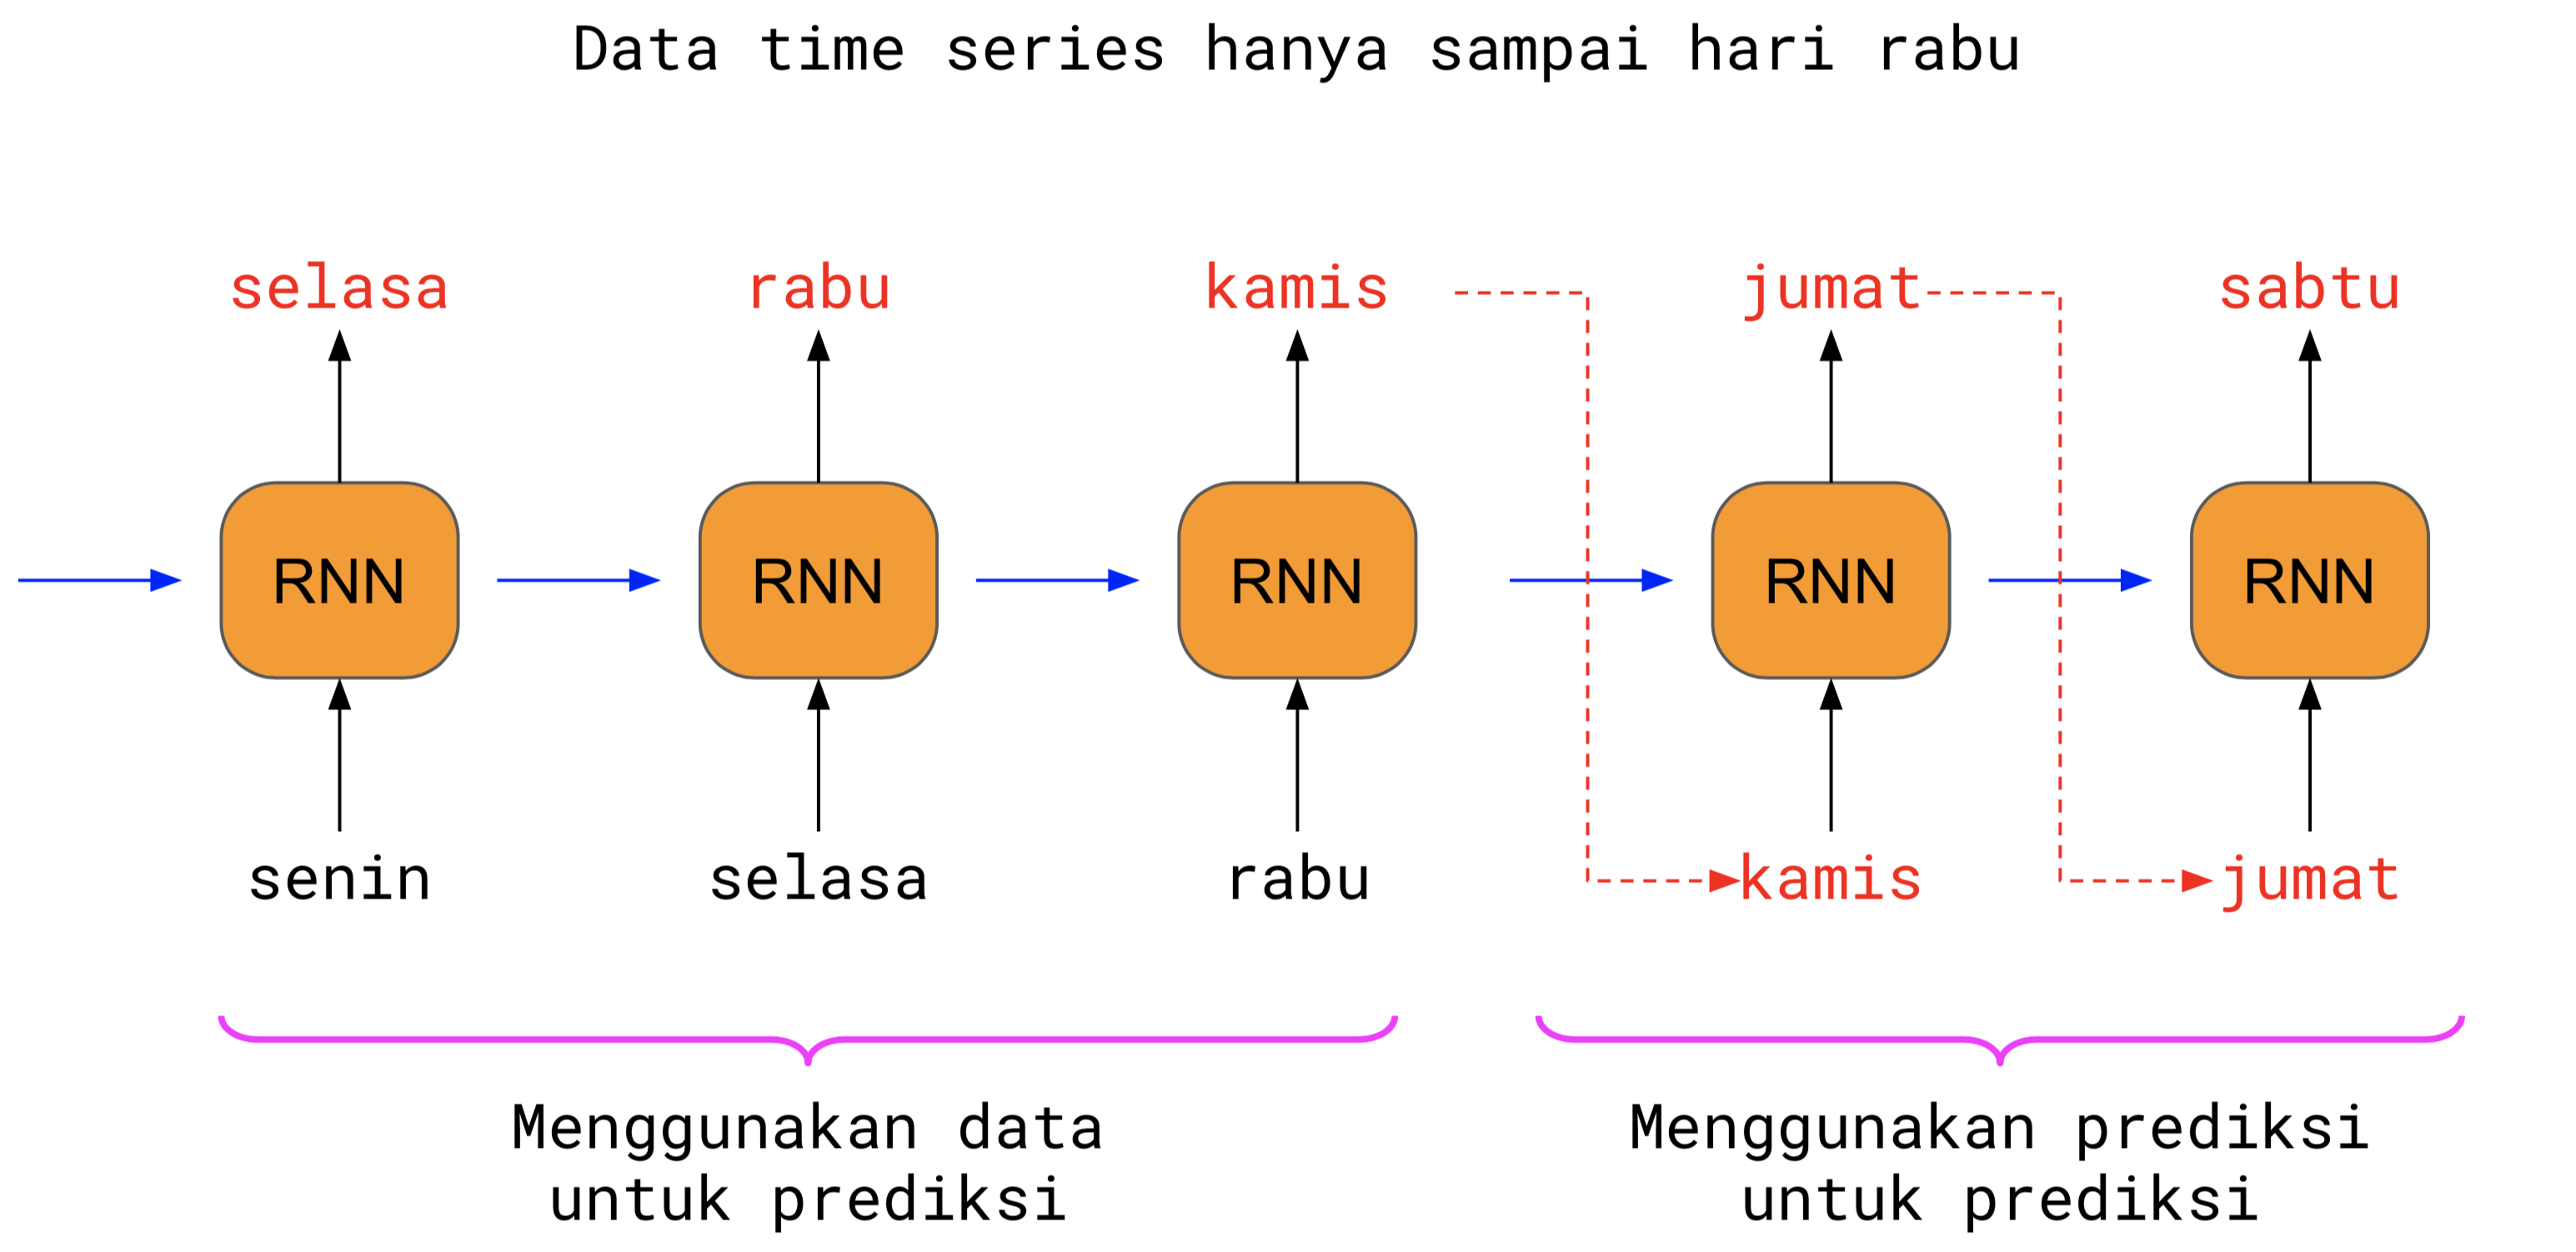

In [50]:
from luwiji.rnn import illustration
illustration.forecast

In [42]:
from utils import data4pred, pred4pred

In [43]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'test')

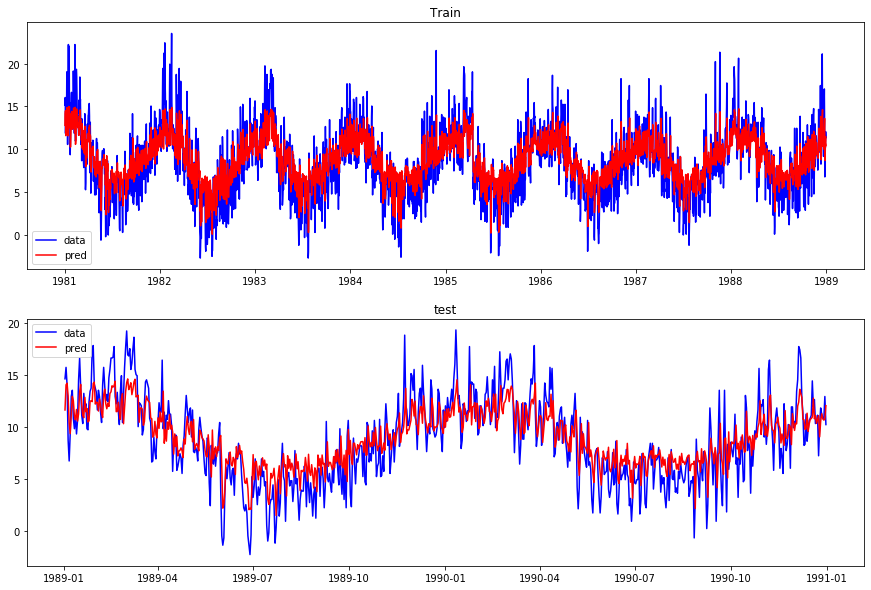

In [44]:
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('test')

### Pred to Pred

Text(0.5, 1.0, 'test')

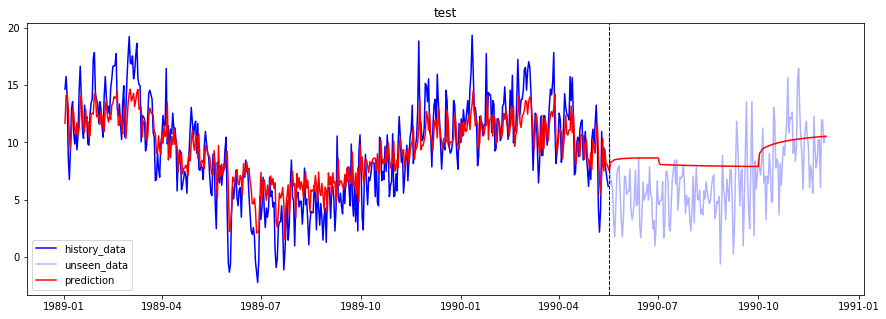

In [45]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('test')